In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fname1 = "electron_30deg_50wob_NOISE120.mscw.fits"
with fits.open(fname1) as hdul:
   df1 = Table.read(hdul[1]).to_pandas()

fname2 = "protons_30deg_5.0wob_NOISE120.mscw.fits"
with fits.open(fname2) as hdul:
   df2 = Table.read(hdul[1]).to_pandas()

# fname3 = "helium_30deg_5.0wob_NOISE120.mscw.fits"
# with fits.open(fname3) as hdul:
#    df3 = Table.read(hdul[1]).to_pandas()

In [3]:
electron = df1.copy()
gamma = electron.iloc[:,:]  # electron and gamma shower identical after first interaction
proton = df2.copy()
hadron = proton.iloc[:,:]  # proton is hadron
#gamma.info()

In [4]:
gamma['class'] = 1  # postive class
hadron['class'] = 0  # negative class

In [5]:
## PRESELECTED CUTS
# gamma = gamma[np.logical_and(gamma['MSCW']>-2.0,gamma['MSCW']<2.0)]
# gamma = gamma[np.logical_and(gamma['MSCL']>-2.0,gamma['MSCL']<5.0)]

gamma['EChi2S'] = np.log10(gamma['EChi2S'])
gamma['EmissionHeightChi2'] = np.log10(gamma['EmissionHeightChi2'])
gamma['SizeSecondMax'] = np.log10(gamma['SizeSecondMax'])

gamma = gamma[np.logical_and(gamma['EChi2S']>-6.0,gamma['EChi2S']<4.0)]
gamma = gamma[np.logical_and(gamma['EmissionHeightChi2']>-6.0,gamma['EmissionHeightChi2']<4.0)]
# gamma = gamma[np.logical_and(gamma['EmissionHeight']>-0.0,gamma['EmissionHeight']<100.0)]
gamma = gamma[np.logical_and(gamma['SizeSecondMax']>-0.0,gamma['SizeSecondMax']<5.0)]
# gamma = gamma[np.logical_and(gamma['dES']>-20, gamma['dES']<20)]
# gamma = gamma[np.logical_and(gamma['Core']>0.0, gamma['Core']<1000.)]

#gamma = gamma.iloc[:450000,:]
gamma.shape

/home/marynaskew/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/marynaskew/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(303042, 60)

In [6]:
# hadron = hadron[np.logical_and(hadron['MSCW']>-2.0,hadron['MSCW']<2.0)]
# hadron = hadron[np.logical_and(hadron['MSCL']>-2.0,hadron['MSCL']<5.0)]

hadron['EChi2S'] = np.log10(hadron['EChi2S'])
hadron['EmissionHeightChi2'] = np.log10(hadron['EmissionHeightChi2'])
hadron['SizeSecondMax'] = np.log10(hadron['SizeSecondMax'])

hadron = hadron[np.logical_and(hadron['EChi2S']>-6.0,hadron['EChi2S']<4.0)]
hadron = hadron[np.logical_and(hadron['EmissionHeightChi2']>-6.0,hadron['EmissionHeightChi2']<4.0)]
# hadron = hadron[np.logical_and(hadron['EmissionHeight']>-0.0,hadron['EmissionHeight']<100.0)]
hadron = hadron[np.logical_and(hadron['SizeSecondMax']>-0.0,hadron['SizeSecondMax']<5.0)]
# hadron = hadron[np.logical_and(hadron['dES']>-20, hadron['dES']<20)]
# hadron = hadron[np.logical_and(hadron['Core']>0.0, hadron['Core']<1000.)]

hadron = hadron.iloc[:303042,:]
hadron.shape

(303042, 60)

In [7]:
particles = gamma.append(hadron)  # combining datasets
particles.shape

/tmp/ipykernel_544/1573789014.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  particles = gamma.append(hadron)  # combining datasets


(606084, 60)

In [8]:
X = particles[['MSCW', 'MSCL', 'EChi2S', 'EmissionHeight', 
               'EmissionHeightChi2', 'SizeSecondMax', 'Core']]
y = particles['class']

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape

(363650, 7)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

2023-08-10 13:04:21.758848: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 13:04:21.815060: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 13:04:22.117824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 13:04:22.120658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 13:04:24.240668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [13]:
# create model
model = Sequential()
model.add(Flatten(input_shape =(X_train.shape[1],1)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [15]:
# Reshape the input data to fit the CNN (assuming one channel)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
# Train the model and track the training history
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=30, shuffle=True,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/20
12122/12122 [==============================] - 52s 4ms/step - loss: 0.2890 - accuracy: 0.8833 - val_loss: 0.2759 - val_accuracy: 0.8893
Epoch 2/20
12122/12122 [==============================] - 61s 5ms/step - loss: 0.2743 - accuracy: 0.8887 - val_loss: 0.2737 - val_accuracy: 0.8895
Epoch 3/20
12122/12122 [==============================] - 45s 4ms/step - loss: 0.2726 - accuracy: 0.8894 - val_loss: 0.2716 - val_accuracy: 0.8900
Epoch 4/20
12122/12122 [==============================] - 47s 4ms/step - loss: 0.2717 - accuracy: 0.8896 - val_loss: 0.2716 - val_accuracy: 0.8903
Epoch 5/20
12122/12122 [==============================] - 45s 4ms/step - loss: 0.2708 - accuracy: 0.8899 - val_loss: 0.2702 - val_accuracy: 0.8907
Epoch 6/20
12122/12122 [==============================] - 44s 4ms/step - loss: 0.2699 - accuracy: 0.8906 - val_loss: 0.2696 - val_accuracy: 0.8908
Epoch 7/20
12122/12122 [==============================] - 51s 4ms/step - loss: 0.2692 - accuracy: 0.8908 - val_loss: 0

In [17]:
from sklearn.metrics import roc_curve, auc

In [18]:
# Get the predicted probabilities for the test set
y_pred = model.predict(X_test_reshaped)

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

7577/7577 [==============================] - 16s 2ms/step
ROC AUC: 0.956029658707133


7577/7577 [==============================] - 12s 2ms/step


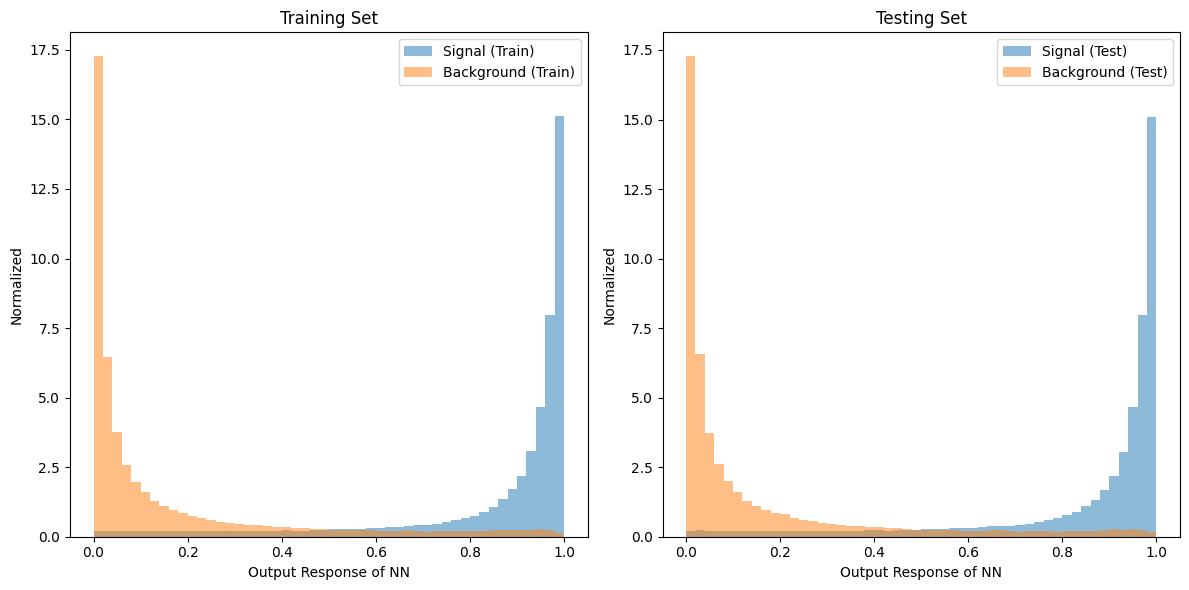

In [19]:
train_signal_probs = model.predict(X_train_reshaped)
test_signal_probs = model.predict(X_test_reshaped)

plt.figure(figsize=(12, 6))

# Plot histograms for signal and background in training set
plt.subplot(1, 2, 1)
plt.hist(train_signal_probs[y_train == 1], bins=50, alpha=0.5, label='Signal (Train)', density = True)
plt.hist(train_signal_probs[y_train == 0], bins=50, alpha=0.5, label='Background (Train)', density = True)
plt.xlabel('Output Response of NN')
plt.ylabel('Normalized')
plt.title('Training Set')
plt.legend()

# Plot histograms for signal and background in testing set
plt.subplot(1, 2, 2)
plt.hist(test_signal_probs[y_test == 1], bins=50, alpha=0.5, label='Signal (Test)', density = True)
plt.hist(test_signal_probs[y_test == 0], bins=50, alpha=0.5, label='Background (Test)', density = True)
plt.xlabel('Output Response of NN')
plt.ylabel('Normalized')
plt.title('Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

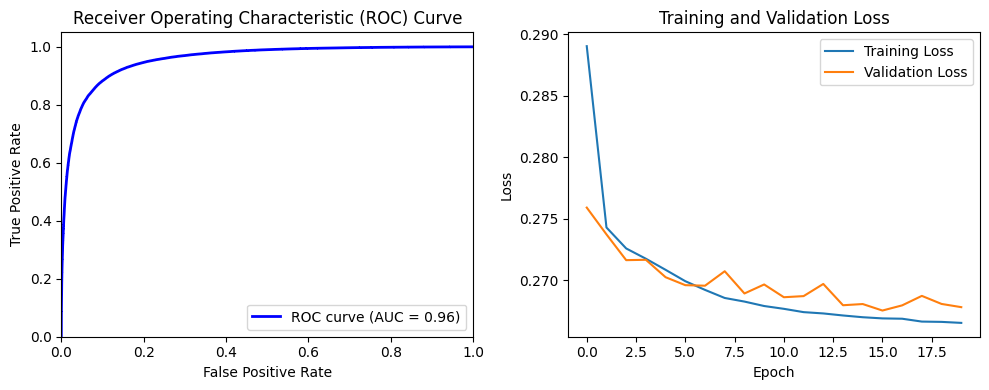

In [22]:
# ROC curve
plt.figure(figsize = (10,4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
import pickle
filename = 'NN_train.sav'
pickle.dump(model, open(filename, 'wb'))